In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pystan
%load_ext jupyterstan

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
STAN_MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "stan_models")

## 几个有用的函数
- save_fig:用于保存仿真的图片到文件

- StanModel_cache: 保存编译好的Stan模型

- StanModel_load: 载入保存的Stan模型


In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# 将编译好的模型，存储成pickle，供直接使用
def StanModel_cache(compiled_model, model_name, **kwargs):
    path = os.path.join(STAN_MODEL_PATH, model_name + '.pkl')
    with open(path,'wb') as f:
        pickle.dump(compiled_model, f)
    print("Model cached as:" + model_name +'.pkl')
    
    
def StanModel_load(model_name):
    path = os.path.join(STAN_MODEL_PATH, model_name + '.pkl')
    try:
        sm = pickle.load(open(path, 'rb'))
    except:
        raise FileNotFoundError
    else:
        print("Using cached StanModel")
    return sm

## 生成发射节点数据

In [3]:
def gen_transmmition_data(i_group_num, i_random_seed,l_trans_power):
    '''
    该函数随机生成生成发送节点的x，y坐标值和发送功率
    Parameters
        ----------
        group_num: int,数据的组数
        random_seed: int,随机数种子
        l_trans_power: iterable,功率值
    Returns
        ----------
        transmmition_data: xarray格式  
    '''
    if (len(l_trans_power) != i_group_num):
        raise ValueError("功率值列表长度应与数据组数一致")

    np.random.seed(i_random_seed)
    trans_x = 0.5 + np.random.rand(i_group_num)*(499.5-0.5)
    trans_y = -499.5 + np.random.rand(i_group_num)*(-0.5+499.5)
    trans_power = np.array([i for i in l_trans_power])
    data = np.stack((trans_x, trans_y, trans_power))
    transmmition_data = xr.DataArray(data,
                              dims=('var', 'group'),
                              coords={'var':['x','y','power']}
                             )
    return transmmition_data


def recv_power(xr_transmmiton_data, coord_x, coord_y, r_η):
    '''
    该函数根据transmmiton_data，节点坐标recv_x, recv_y, 自由空间传播损耗因子η，生成每个节点的接收功率
    Parameters
        ----------
        xr_transmmion_data: xarray,发送节点数据,dims{var,group}
        recv_x: np.meshgrid生成的x坐标
        recv_y: np.meshgrid生成的y坐标
        r_η: real,自由空间传播损耗
    Returns
        ----------
        spectrum_data: xarray格式<xarray.DataArray (y: 500, x: 500, group: n)>    
    '''
    recv_x, recv_y = np.meshgrid(coord_x, coord_y)
    groups = xr_transmmiton_data.sizes['group']
    temp_array = np.zeros(shape=(len(recv_x), len(recv_y), groups))
    for group_num in range(groups):
        trans_x , trans_y, trans_power = xr_transmmiton_data.sel(group=group_num).values
        recv_power = trans_power - 10 * r_η * np.log10( np.sqrt(np.square(recv_x-trans_x)
               +np.square(recv_y-trans_y)) )
        temp_array[:,:,group_num] = recv_power
    
    spectrum_data = xr.DataArray(temp_array,
                             dims=('y', 'x', 'group'),
                            coords={'x':coord_x , 'y':coord_y})
        
    return spectrum_data

In [4]:
transmmition_data = gen_transmmition_data(20, 1234, [30, 50,40, 30, 40, 50, 30, 40, 50,30, 50,40, 30, 40, 50, 30, 40, 50,35,35])

In [5]:
transmmition_data

<xarray.DataArray (var: 3, group: 20)>
array([[  96.06820574,  310.93227675,  218.92614176,  392.39393327,
         389.70792825,  136.52371004,  138.45566332,  400.63421659,
         478.61153749,  437.59038474,  179.05081771,  250.49656764,
         341.54800465,  356.13831146,  185.25512664,  280.53689685,
         251.53849949,    7.37045635,  386.14048418,  440.93795413],
       [-317.42189403, -192.41730696, -461.88476042, -315.45682101,
         -33.86308911, -174.46230653, -301.29591371, -105.92365867,
        -341.39877504, -216.01877234,  -65.80543261, -281.84946148,
         -99.2283266 , -427.76035457, -148.07377541, -147.91392721,
        -390.32273927,  -37.99105332, -278.87176305,  -45.75133647],
       [  30.        ,   50.        ,   40.        ,   30.        ,
          40.        ,   50.        ,   30.        ,   40.        ,
          50.        ,   30.        ,   50.        ,   40.        ,
          30.        ,   40.        ,   50.        ,   30.        ,
          40.        ,   50.        ,   35.        ,   35.        ]])
Coordinates:
  * var      (var) <U5 'x' 'y' 'power'
Dimensions without coordinates: group

## 生成每个节点的接收功率
根据发送节点数据，生成同样组数的各个接收节点的功率

In [5]:
coord_x = np.arange(0.5, 500, 1)
coord_y = np.arange(-499.5, 0, 1)

In [6]:
free_loss_data = recv_power(transmmition_data, coord_x, coord_y, 3.5)

## 加入阴影衰落的影响

In [7]:
rf=xr.open_dataset('rf_200_8.nc')
rf = rf['__xarray_dataarray_variable__']

In [8]:
def add_shadow_fading(xr_spectrum_data, xr_random_field):
    for i in range(xr_spectrum_data.sizes['group']):    
        xr_spectrum_data[dict(group=i)]-= xr_random_field[dict(band=0)]
    return xr_spectrum_data

In [9]:
shadow_loss_data = add_shadow_fading(free_loss_data, rf)

In [27]:
shadow_loss_data.to_netcdf('shadow_loss_data.nc')

## 从中抽取100点模拟感知信号

In [10]:
x_ = np.arange(24.5, 500, 50)
y_ = np.arange(-474.5, 0, 50)

In [11]:
sensor_data = shadow_loss_data.loc[dict(x=x_,y=y_)]

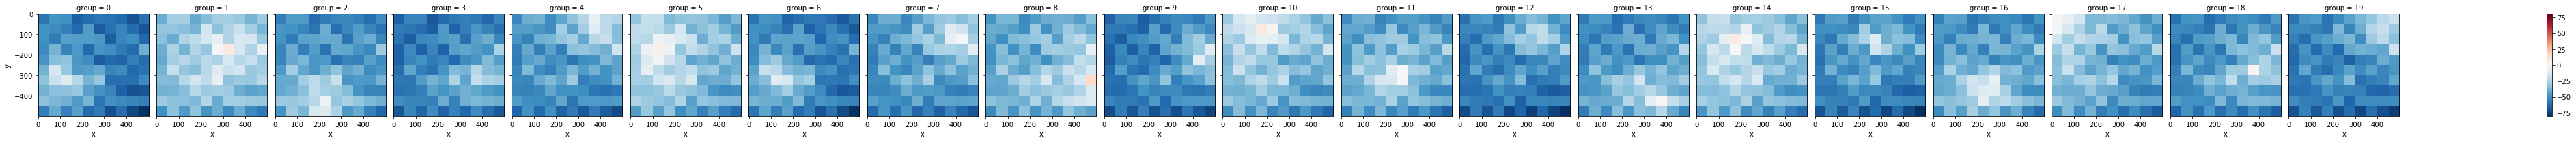

In [12]:
sensor_data.plot.imshow(col='group')

In [14]:
def add_sensor_error(xr_sensor_data, error):
    for i in range(xr_sensor_data.sizes['group']):    
        xr_sensor_data[dict(group=i)]+= np.random.randn(10,10)
    return xr_sensor_data

In [15]:
sensor_data_with_error = add_sensor_error(sensor_data, sensor_error)

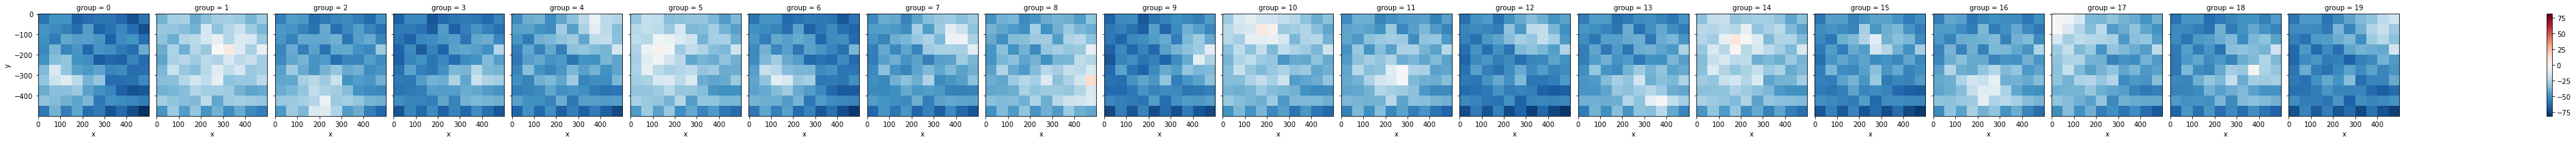

In [16]:
sensor_data_with_error.plot.imshow(col='group')

## 随机抽取

In [22]:
coord_x = np.arange(0.5, 500, 1)
coord_y = np.arange(-499.5, 0, 1)

## 生成stan数据

In [18]:
def stan_data_gen(xr_transmmition_data, xr_sensor_data):
    stan_data = {}
    stan_data['D'] = xr_transmmition_data.sizes['group']
    stan_data['N'] = xr_sensor_data.size//xr_sensor_data.sizes['group']
    tempx, tempy = np.meshgrid(xr_sensor_data.x.values, xr_sensor_data.y.values) 
    stan_data['recv_x'] = list(tempx.flat)
    stan_data['recv_y'] = list(tempy.flat)
    
    stan_data['tran_power'] = list(xr_transmmition_data.sel(var='power').values)
    stan_data['tran_x'] = list(xr_transmmition_data.sel(var='x').values)
    stan_data['tran_y'] = list(xr_transmmition_data.sel(var='y').values)
    
    stan_data['tran_recv_distance'] = []
    stan_data['Y'] = []
    
    for group_num in range(xr_sensor_data.sizes['group']):
        trans_x , trans_y, _ = xr_transmmition_data.sel(group=group_num).values
        distances = np.sqrt(np.square( tempx - trans_x) + np.square(tempy-trans_y))
        
        stan_data['tran_recv_distance'].append(list(distances.flat))
        stan_data['Y'].append(list(xr_sensor_data.sel(group=group_num).values.flat))
        
    return stan_data

In [19]:
stan_data = stan_data_gen(transmmition_data, sensor_data_with_error)

## 用pystan进行仿真

In [ ]:
%%stan prior_model
functions {
  matrix cov_exponential(matrix distance_between, real sigma, real fai) {
    int N=rows(distance_between);
    matrix[N, N] cov;
    for (i in 1:N){
      for (j in 1:N){
        if (i==j)
          cov[i, j] = 1;
        else
          cov[i,j] = square(sigma) * exp(-1*fai*distance_between[i,j]);
      }
    }    
    return cov;
  }
}

data {
  int<lower=1> D; //数据组数
  int<lower=1> N; //感知节点个数
  vector[N] recv_x;// 每组数据有N个感知节点
  vector[N] recv_y;// 
  real tran_power[D]; //信号源发送功率
  real tran_x[D]; //信号源坐标
  real tran_y[D];
  vector[N] tran_recv_distance[D]; 
}

transformed data {
  matrix[N, N] distance_between_recv;
  for (i in 1:N){
    for (j in 1:N){
      distance_between_recv[i,j] = sqrt((recv_x[i]-recv_x[j])^2 + (recv_y[i]-recv_y[j])^2);
    }
  }
}

generated quantities {
  real gama; // 自由空间传播损耗因子
  real fai;  // matern 协方差函数的距离 参数
  real sigma; // 空间方差  
  real sigma_eta; // 测量误差
  //vector[N] Y[D];

  matrix[N,N] bigSigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  
  /********************/
  /*    指定先验分布    */
  /********************/
  gama = uniform_rng(1,10);
  fai = normal_rng(20, 100);
  sigma = inv_gamma_rng(2, 10);
  sigma_eta = inv_gamma_rng(2, 10);
 
  
  
  //bigSigma = cov_exponential(distance_between_recv, sigma, fai) + square(sigma_eta)*unit_matrix;
  //for (i in 1:D) {
  //  Y[i] = multi_normal_rng(tran_power[i] - 10 * gama * log10(tran_recv_distance[i]), bigSigma); 
 // }
}


In [ ]:
stan_data.pop('Y')

In [ ]:
fit_prior = porior.sampling(data=stan_data,iter=10000, chains=1, algorithm='Fixed_param', warmup=0)

In [ ]:
az_f = az.from_pystan(prior=fit_prior)

In [ ]:
az_f.prior.sigma.plot.hist()

#### exponential相关函数模型

In [ ]:
%%stan exponential_cov
functions {
  matrix cov_exponential(matrix distance_between, real sigma, real fai) {
    int N=rows(distance_between);
    matrix[N, N] cov;
    for (i in 1:N){
      for (j in 1:N){
        if (i==j)
          cov[i, j] = 1;
        else
          cov[i,j] = square(sigma) * exp(-1*fai*distance_between[i,j]);
      }
    }
    
    return cov;
  }
}

data {
  int<lower=1> D; //数据组数
  int<lower=1> N; //感知节点个数
  vector[N] recv_x;// 每组数据有N个感知节点
  vector[N] recv_y;// 
  real tran_power[D]; //信号源发送功率
  real tran_x[D]; //信号源坐标
  real tran_y[D];
  vector[N] tran_recv_distance[D];
  vector[N] Y[D];
 
}

transformed data {
  matrix[N, N] distance_between_recv;
  for (i in 1:N){
    for (j in 1:N){
      distance_between_recv[i,j] = sqrt((recv_x[i]-recv_x[j])^2 + (recv_y[i]-recv_y[j])^2);
    }
  }
}

parameters {
  real gama; // 自由空间传播损耗因子
  real fai;  // matern 协方差函数的距离 参数
  real sigma; // 空间方差  
  real sigma_eta; // 测量误差
}
transformed parameters {

}

model {
  matrix[N,N] bigSigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  
  /********************/
  /*    指定先验分布    */
  /********************/
  gama ~ uniform(1,10);
  fai ~ normal(20, 100);
  sigma ~ inv_gamma(2, 10);
  sigma_eta ~ inv_gamma(2, 10);
 
  
  
  bigSigma = cov_exponential(distance_between_recv, sigma, fai) + square(sigma_eta)*unit_matrix;
  for (i in 1:D){
    Y[i] ~ multi_normal(tran_power[i] - 10 * gama * log10(tran_recv_distance[i]), bigSigma); 
  }
   
}

#### exp模型，sigma_eta 先验改变

In [ ]:
%%stan exponential_cov
functions {
  matrix cov_exponential(matrix distance_between, real sigma, real fai) {
    int N=rows(distance_between);
    matrix[N, N] cov;
    for (i in 1:N){
      for (j in 1:N){
        if (i==j)
          cov[i, j] = 1;
        else
          cov[i,j] = square(sigma) * exp(-1*fai*distance_between[i,j]);
      }
    }
    
    return cov;
  }
}

data {
  int<lower=1> D; //数据组数
  int<lower=1> N; //感知节点个数
  vector[N] recv_x;// 每组数据有N个感知节点
  vector[N] recv_y;// 
  real tran_power[D]; //信号源发送功率
  real tran_x[D]; //信号源坐标
  real tran_y[D];
  vector[N] tran_recv_distance[D];
  vector[N] Y[D];
 
}

transformed data {
  matrix[N, N] distance_between_recv;
  for (i in 1:N){
    for (j in 1:N){
      distance_between_recv[i,j] = sqrt((recv_x[i]-recv_x[j])^2 + (recv_y[i]-recv_y[j])^2);
    }
  }
}

parameters {
  real gama; // 自由空间传播损耗因子
  real fai;  // matern 协方差函数的距离 参数
  real sigma; // 空间方差  
  real sigma_eta; // 测量误差
}
transformed parameters {

}

model {
  matrix[N,N] bigSigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  
  /********************/
  /*    指定先验分布    */
  /********************/
  gama ~ uniform(1,10);
  fai ~ normal(20, 100);
  sigma ~ inv_gamma(2, 10);
  sigma_eta ~ inv_gamma(2, 1);
 
  
  
  bigSigma = cov_exponential(distance_between_recv, sigma, fai) + square(sigma_eta)*unit_matrix;
  for (i in 1:D){
    Y[i] ~ multi_normal(tran_power[i] - 10 * gama * log10(tran_recv_distance[i]), bigSigma); 
  }
   
}

In [20]:
%%stan expo
functions {
  matrix cov_exponential(matrix distance_between, real sigma, real fai) {
    int N=rows(distance_between);
    matrix[N, N] cov;
    for (i in 1:N){
      for (j in 1:N){
        if (i==j)
          cov[i, j] = 1;
        else
          cov[i,j] = square(sigma) * exp(-1*fai*distance_between[i,j]);
      }
    }
    
    return cov;
  }
}

data {
  int<lower=1> D; //数据组数
  int<lower=1> N; //感知节点个数
  vector[N] recv_x;// 每组数据有N个感知节点
  vector[N] recv_y;// 
  real tran_power[D]; //信号源发送功率
  real tran_x[D]; //信号源坐标
  real tran_y[D];
  vector[N] tran_recv_distance[D];
  vector[N] Y[D];
 
}

transformed data {
  matrix[N, N] distance_between_recv;
  for (i in 1:N){
    for (j in 1:N){
      distance_between_recv[i,j] = sqrt((recv_x[i]-recv_x[j])^2 + (recv_y[i]-recv_y[j])^2);
    }
  }
}

parameters {
  real gama; // 自由空间传播损耗因子
  real fai;  // matern 协方差函数的距离 参数
  real sigma; // 空间方差  
 // real sigma_eta; // 测量误差
}
transformed parameters {

}

model {
  matrix[N,N] bigSigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  
  /********************/
  /*    指定先验分布    */
  /********************/
  gama ~ uniform(1,10);
  fai ~ normal(20, 100);
  sigma ~ inv_gamma(2, 10);
  //sigma_eta ~ inv_gamma(2, 1);
 
  
  
  bigSigma = cov_exponential(distance_between_recv, sigma, fai); //+ square(sigma_eta)*unit_matrix;
  for (i in 1:D){
    Y[i] ~ multi_normal(tran_power[i] - 10 * gama * log10(tran_recv_distance[i]), bigSigma); 
  }
   
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL expo_1593669845d11594b3567e375de3f771 NOW.


Creating pystan model & assigning it to variable name "expo".
Stan options:
 {'model_name': 'expo', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "expo"!
Compilation took a minute.


In [21]:
fit_exp = expo.sampling(data=stan_data, iter=10000, chains=1)

/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3dd3029e10>,
      dtype=object)

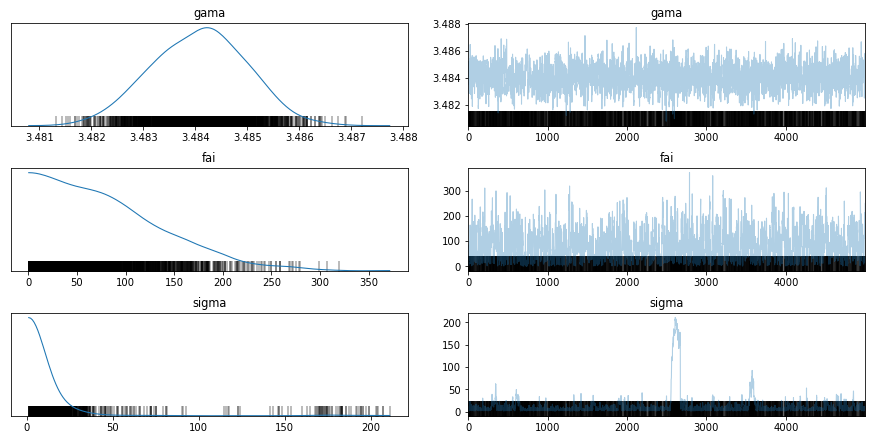

In [24]:
az.plot_trace(fit_exp)

In [ ]:
from scipy.stats import invgamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a=2
x = np.linspace(invgamma.ppf(0.01, a, scale=1), invgamma.ppf(0.99, a,scale=1), 100)
ax.plot(x, invgamma.pdf(x, a,scale=1),'r-', lw=5, alpha=0.6, label='invgamma pdf')2

In [ ]:
invgamma.ppf?

In [ ]:
code_hash = md5(exponential_cov.model_code.encode('utf-8')).hexdigest()
code_hash

In [ ]:
exponential_cov.

In [ ]:
ex